In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev2, Chebyshev_L3

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

import uqtestfuns as uqtf
import numpy as np
from poly_utils import MLP_model, fit, Regression, generate_dataset_uqtf, evaluate, non_zero_count, sparse_model, add_multi_index, prod_multi_index
import poly_utils as ut
from Cuda import DeviceDataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import copy

/home/ashish-razer/Programs/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
my_testfun =  uqtf.Borehole()
print(my_testfun)
my_testfun.spatial_dimension

Name              : Borehole
Spatial dimension : 8
Description       : Borehole function from Harper and Gupta (1983)


8

In [3]:
#my_testfun.prob_input
np.random.seed(42)

In [4]:
N = 10000
train = 0.9
N_t = int(N * train)
N_v = N - N_t



In [75]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
NUM_EPOCHS = 5
RANK = 25
DEGREE = 3
LHP = 20
IN_DIM = my_testfun.spatial_dimension
OUT_DIM = 1

loss_fn = nn.MSELoss()

In [76]:
np.random.seed(42)
dataset, target_scaler = generate_dataset_uqtf(my_testfun, N, MinMaxScaler())

In [77]:
train_ds, val_ds = random_split(dataset, [N_t, N_v])

In [78]:
train_loader = DeviceDataLoader(DataLoader(train_ds, BATCH_SIZE, shuffle=True), device)
val_loader = DeviceDataLoader(DataLoader(val_ds, BATCH_SIZE), device)

In [79]:
#inverse = target_scaler.inverse_transform(yy_sample)


In [80]:
Canon = CP(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
Cheby = Chebyshev(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
Mlp = MLP_model(IN_DIM, OUT_DIM)
Mlp_reg = Regression(Mlp, IN_DIM, loss_fn).to(device)
Canon_reg = Regression(Canon, IN_DIM, loss_fn).to(device)
Cheby_reg = Regression(Cheby, IN_DIM, loss_fn).to(device)
#optimizer = torch.optim.Adam
#optimizer = torch.optim.SGD
optimizer = torch.optim.Rprop
#optimizer = torch.optim.LBFGS

In [81]:
optimizer_list = [torch.optim.Adam, torch.optim.SGD, torch.optim.Rprop]
models = [Mlp_reg, Canon_reg, Cheby_reg]

In [82]:
param_count = np.zeros(len(models))
for i in range(len(models)):
    print(non_zero_count(models[i]))
    param_count[i] = non_zero_count(models[i])


tensor(761)
tensor(626)
tensor(650)


In [83]:
df_param = pd.DataFrame(param_count, index= ['MLP', 'Canonical', 'Chebyshev'] )

In [84]:
df_param

,0
MLP,761.0
Canonical,626.0
Chebyshev,650.0


In [85]:
index= ['MLP', 'Canonical', 'Chebyshev']

In [86]:
n = len(models)
ensemble = [[] for _ in range(n)]


In [87]:
for i in range(n):
    for j in range(len(optimizer_list)):
        model_clone = copy.deepcopy(models[i])
        ensemble[i].append(model_clone)

In [88]:
for i in range(n):
    for j in range(len(optimizer_list)):
        #print(ensemble[i][j])
        #print(optimizer_list[j])
        history, losses = fit(NUM_EPOCHS, LEARNING_RATE, ensemble[i][j], train_loader, val_loader, opt_func=optimizer_list[j])

Epoch [0], train_loss: 0.0442 val_loss: 0.0538
Epoch [1], train_loss: 0.0356 val_loss: 0.0335
Epoch [2], train_loss: 0.0181 val_loss: 0.0203
Epoch [3], train_loss: 0.0176 val_loss: 0.0129
Epoch [4], train_loss: 0.0070 val_loss: 0.0089
Epoch [0], train_loss: 0.0827 val_loss: 0.0766
Epoch [1], train_loss: 0.0717 val_loss: 0.0723
Epoch [2], train_loss: 0.0542 val_loss: 0.0683
Epoch [3], train_loss: 0.0536 val_loss: 0.0646
Epoch [4], train_loss: 0.0816 val_loss: 0.0612
Epoch [0], train_loss: 0.0013 val_loss: 0.0009
Epoch [1], train_loss: 0.0011 val_loss: 0.0009
Epoch [2], train_loss: 0.0006 val_loss: 0.0009
Epoch [3], train_loss: 0.0026 val_loss: 0.0009
Epoch [4], train_loss: 0.0012 val_loss: 0.0008
Epoch [0], train_loss: 0.1761 val_loss: 0.1682
Epoch [1], train_loss: 0.1246 val_loss: 0.1153
Epoch [2], train_loss: 0.0560 val_loss: 0.0785
Epoch [3], train_loss: 0.0488 val_loss: 0.0527
Epoch [4], train_loss: 0.0445 val_loss: 0.0355
Epoch [0], train_loss: 0.2343 val_loss: 0.2366
Epoch [1], tr

In [89]:
ensemble_array = np.array(ensemble)

In [90]:
np.random.seed(44)
mse_array = np.zeros_like(ensemble_array)
linf_array = np.zeros_like(ensemble_array)
test_dataset, target_scaler_test = generate_dataset_uqtf(my_testfun, N, MinMaxScaler())
for i in range(n):
    for j in range(len(optimizer_list)):
        model = ensemble_array[i,j].to('cpu').eval()
        outputs = model(test_dataset[:, :IN_DIM].to('cpu')).to('cpu').detach().numpy()
        outputs = torch.tensor(target_scaler.inverse_transform(outputs)) 
        test_target = test_dataset[:, IN_DIM:].to('cpu').detach().numpy()
        test_target = torch.tensor(target_scaler.inverse_transform(test_target) )
        mse = loss_fn(outputs, test_target).detach().item()
        mse_array[i,j] = mse

        l_inf = torch.max(abs(outputs-test_target)).item()
        linf_array[i,j] = l_inf

In [91]:
linf_array

array([[162.41770935058594, 232.66807556152344, 101.07881164550781],
       [180.41871643066406, 365.7162170410156, 97.20599365234375],
       [190.72467041015625, 250.69271850585938, 191.32957458496094]],
      dtype=object)

In [92]:
mse_array

array([[620.5051879882812, 3623.715576171875, 63.32484436035156],
       [2002.2418212890625, 10649.8212890625, 60.846649169921875],
       [4442.55859375, 5541.28076171875, 4600.0205078125]], dtype=object)

In [93]:

df_linf = pd.DataFrame(linf_array, index= ['MLP', 'Canonical', 'Chebyshev'], columns =['Adam', 'SGD', 'Rprop'] )

In [94]:
df_linf

,Adam,SGD,Rprop
MLP,162.417709,232.668076,101.078812
Canonical,180.418716,365.716217,97.205994
Chebyshev,190.72467,250.692719,191.329575


In [95]:
df_mse = pd.DataFrame(mse_array, index= ['MLP', 'Canonical', 'Chebyshev'], columns =['Adam', 'SGD', 'Rprop'] )

In [96]:
df_mse

,Adam,SGD,Rprop
MLP,620.505188,3623.715576,63.324844
Canonical,2002.241821,10649.821289,60.846649
Chebyshev,4442.558594,5541.280762,4600.020508


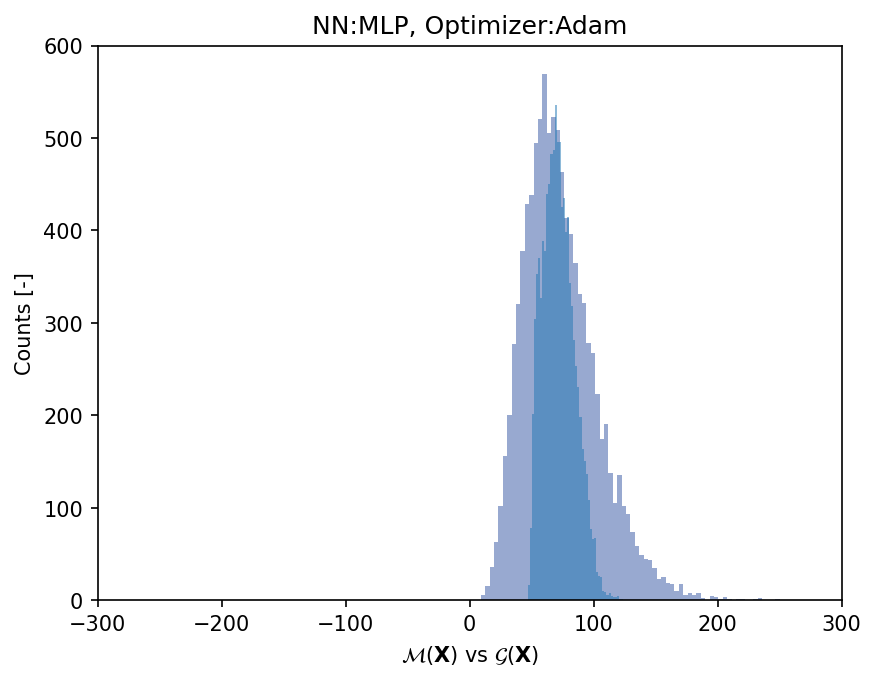

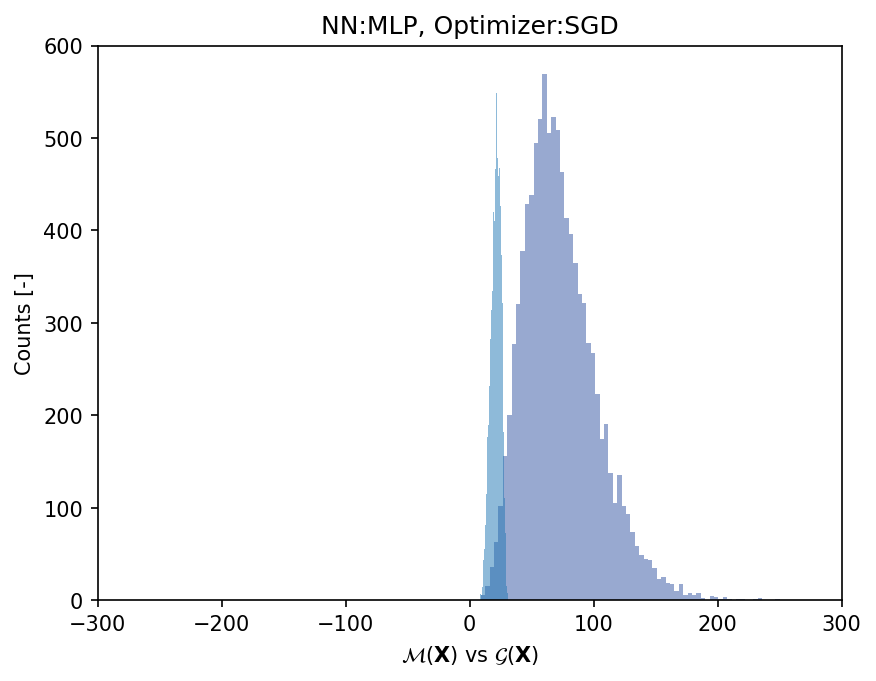

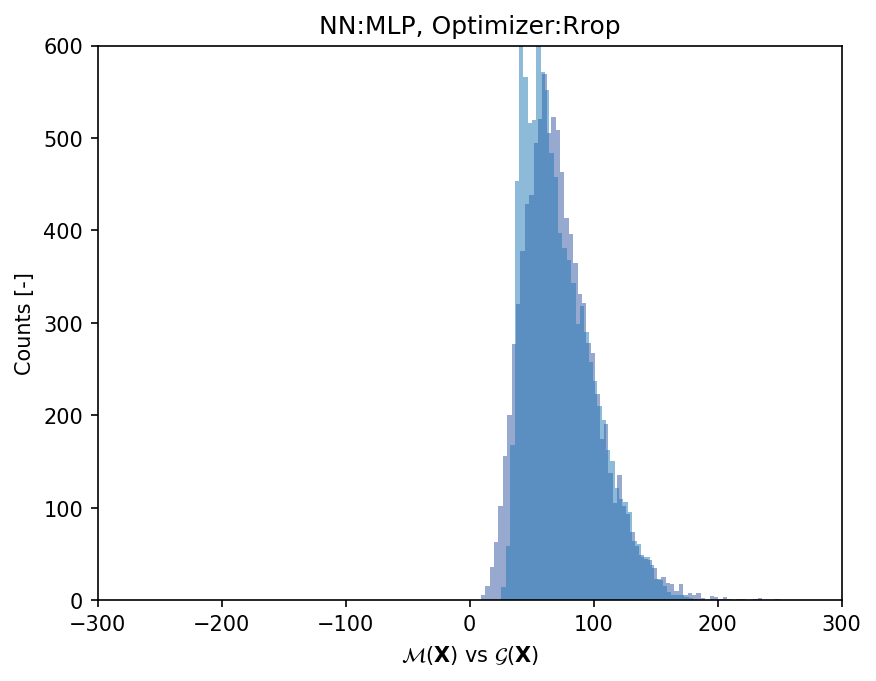

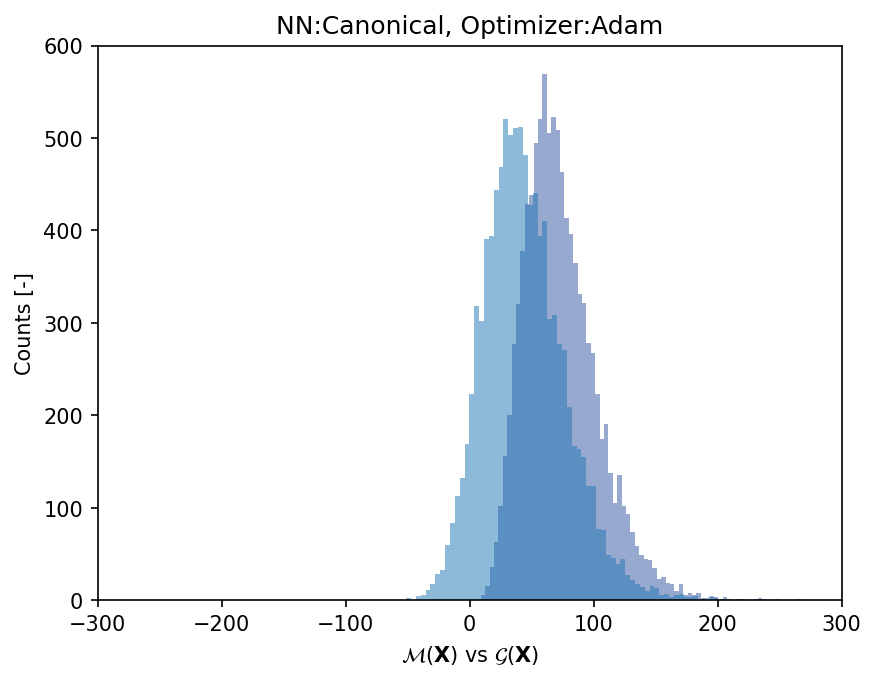

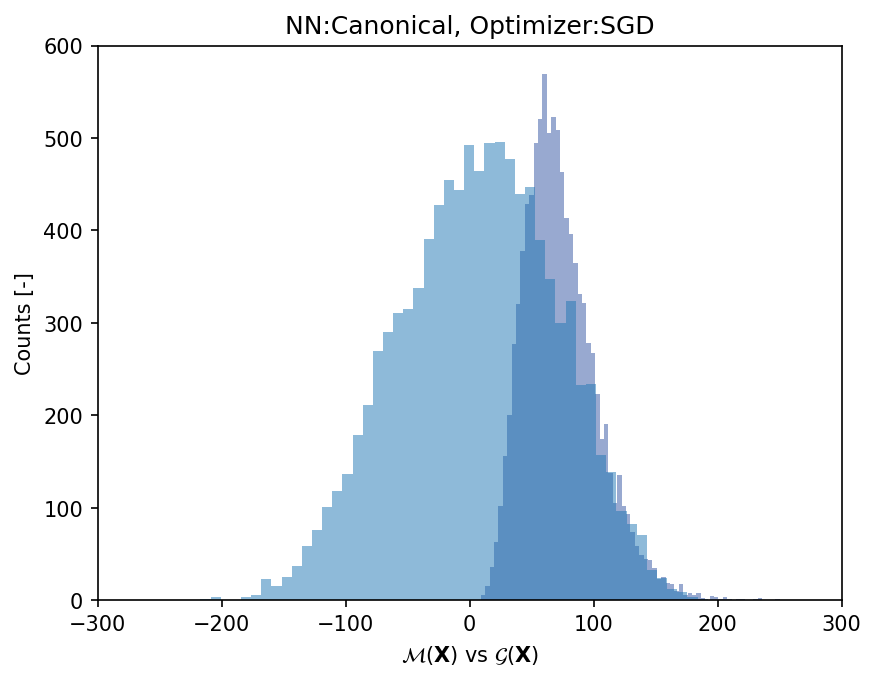

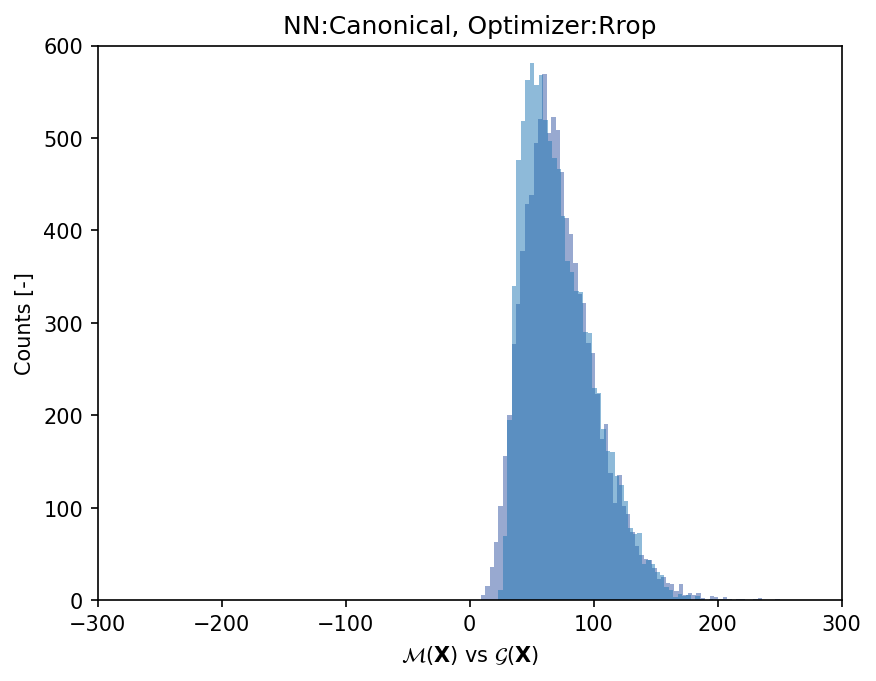

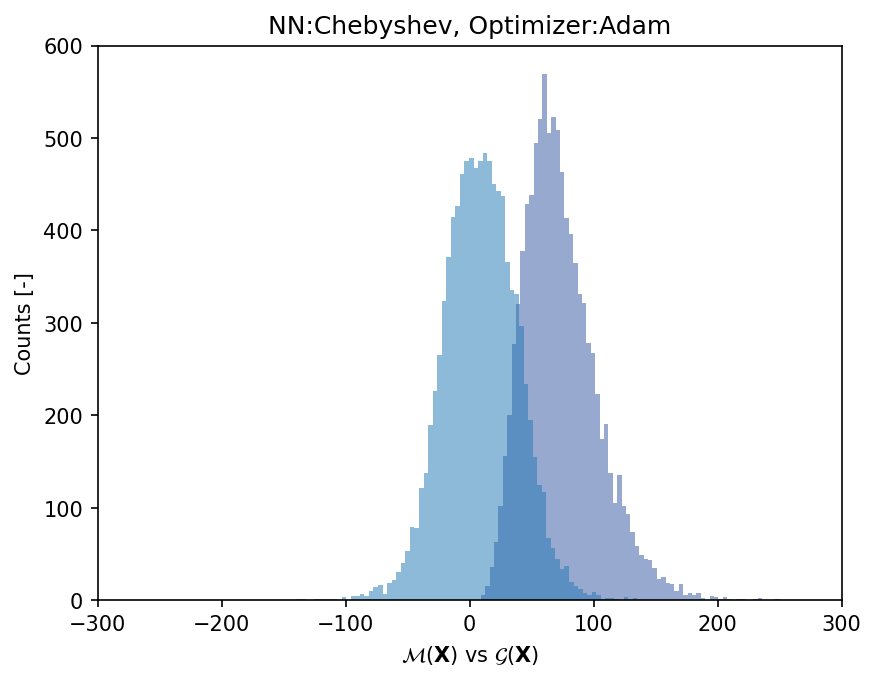

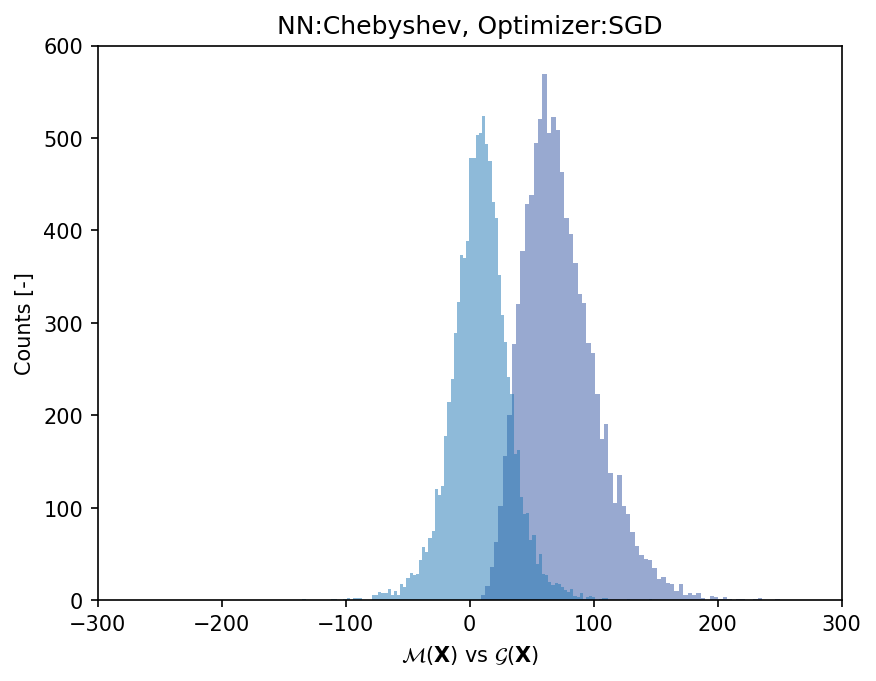

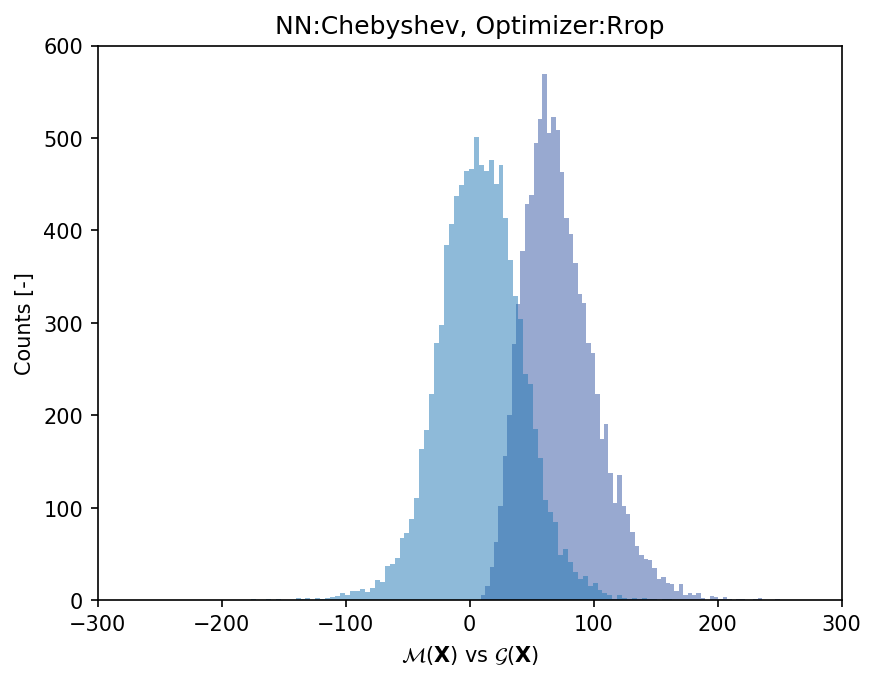

In [97]:
np.random.seed(44)
test_dataset, target_scaler_test = generate_dataset_uqtf(my_testfun, N, MinMaxScaler())

model_name = ['MLP', 'Canonical', 'Chebyshev']
Optimizer_name = ['Adam', 'SGD', 'Rrop']
for i in range(len(models)):
    for j in range(len(optimizer_list)):
        model = ensemble_array[i,j].to('cpu')
        outputs = model(test_dataset[:, :IN_DIM].to('cpu')).to('cpu').detach().numpy()
        outputs = target_scaler.inverse_transform(outputs)
        test_target = test_dataset[:, IN_DIM:].to('cpu').detach().numpy()
        test_target = target_scaler.inverse_transform(test_target)
    
        
        fig1 = plt.figure()
        plt.hist(test_target, bins="auto", color="#8da0cb", alpha = 0.9)
        plt.hist(outputs, bins='auto', alpha = 0.5)
        plt.xlim(-300, 300)
        plt.ylim(0, 600)
        plt.title('NN:' + model_name[i] +', Optimizer:'+ Optimizer_name[j])
        #plt.title(Optimizer_name[j])
        plt.xlabel("$\mathcal{M}(\mathbf{X})$ vs $\mathcal{G}(\mathbf{X})$")
        plt.ylabel("Counts [-]")
        plt.gcf().set_dpi(150);
        #plt.figure(1)


In [98]:
model.to('cpu')

Regression(
  (model): Chebyshev(
    (T1): Linear(in_features=8, out_features=25, bias=False)
    (T2): Linear(in_features=8, out_features=25, bias=False)
    (T3): Linear(in_features=8, out_features=25, bias=False)
    (layer_C): Linear(in_features=25, out_features=1, bias=False)
  )
  (loss_function): MSELoss()
)

In [99]:
np.random.seed(44)
test_dataset, target_scaler_test = generate_dataset_uqtf(my_testfun, N, MinMaxScaler())
test_target = test_dataset[:, IN_DIM:].to('cpu').detach().numpy()
test_target_scaled = target_scaler.inverse_transform(test_target)

In [100]:
non_zero_count(model)

tensor(650)

In [101]:
Cheby = Chebyshev(DEGREE, IN_DIM, 1, OUT_DIM).to(device)
Cheby_reg = Regression(Cheby, IN_DIM, loss_fn).to(device)
optimizer = optimizer = torch.optim.Adam

In [102]:
non_zero_count(Cheby_reg)

tensor(26)

In [103]:
for name, p in Cheby_reg.named_parameters():
    print(name, p)

model.T0 Parameter containing:
tensor([-0.9930], device='cuda:0', requires_grad=True)
model.T1.weight Parameter containing:
tensor([[ 0.1722, -0.2653,  0.2658, -0.0678, -0.3488,  0.3224, -0.3215,  0.1072]],
       device='cuda:0', requires_grad=True)
model.T2.weight Parameter containing:
tensor([[-0.2146, -0.2769,  0.0859,  0.1150, -0.1363,  0.0233, -0.0045,  0.2189]],
       device='cuda:0', requires_grad=True)
model.T3.weight Parameter containing:
tensor([[ 0.1621,  0.0621, -0.2001, -0.1964,  0.3109,  0.1101,  0.2124,  0.2832]],
       device='cuda:0', requires_grad=True)
model.layer_C.weight Parameter containing:
tensor([[-0.9286]], device='cuda:0', requires_grad=True)


In [104]:
history, losses = fit(NUM_EPOCHS, LEARNING_RATE, Cheby_reg, train_loader, val_loader, opt_func=optimizer)

Epoch [0], train_loss: 0.7290 val_loss: 0.7589
Epoch [1], train_loss: 0.7249 val_loss: 0.6332
Epoch [2], train_loss: 0.5917 val_loss: 0.5384
Epoch [3], train_loss: 0.4452 val_loss: 0.4636
Epoch [4], train_loss: 0.5391 val_loss: 0.4037


In [105]:
#sparse_cheby = ut.sparse_model(copy.deepcopy(Cheby_reg), 0.2)
sparse_params_cheby = ut.params_Cheby(Cheby_reg.model)
mi_list_cheby_1 = ut.multi_indices_list_Cheby(sparse_params_cheby)
mi_net_cheby_1 = ut.multi_indices_net_Cheby(mi_list_cheby_1, DEGREE)

IndexError: list index out of range

In [ ]:
mi_list_cheby_1[2]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
mi_sum = mi_net_cheby_1.sum(axis=1)

In [ ]:
#mi_sum = np.sum(mi_list_cheby_1, axis =1)

In [ ]:
sparse_cheby = ut.sparse_model(copy.deepcopy(Cheby_reg), 0.2)
sparse_params_cheby = ut.params_Cheby(sparse_cheby.model)
mi_list_cheby = ut.multi_indices_list_Cheby(sparse_params_cheby)
mi_net_cheby = ut.multi_indices_net_Cheby(mi_list_cheby, DEGREE)

In [ ]:
mi_net_cheby.shape

(691, 8)

In [ ]:
np.savetxt('multi_indices.csv', mi_net_cheby, delimiter=',')
np.savetxt('data.csv', dataset, delimiter=',')
np.savetxt('test_data.csv', test_dataset, delimiter=',')
np.savetxt('test_target_scaled.csv', test_target_scaled, delimiter=',')

In [ ]:
sparse_cheby.model.T2.weight

Parameter containing:
tensor([[-0.2746, -0.2845, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000]],
       device='cuda:0', requires_grad=True)

In [ ]:
import numpy as np
import minterpy as mp
import matplotlib.pyplot as plt
import scipy
from minterpy.utils import eval_newton_polynomials

ModuleNotFoundError: No module named 'minterpy'

https://github.com/polynomial-nets/tutorial-2022-intro-polynomial-nets/blob/master/pytorch/Minimum_example_pytorch.ipynb